https://www.youtube.com/watch?v=XyX5HNuv-xE

- need to check how the images are normalized (see unet tutorials)
- why is he adding another dimensions for the training and testing??

In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

import os
import datetime
import sys
import random
import warnings
import glob
import re
import numpy as np
import pandas as pd
import imageio

import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras.layers import Input, RandomCrop
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
#from tf.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical, normalize

from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
optimizer = tf.keras.optimizers.Adam()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Load data

In [ ]:
IMG_WIDTH = 128#96#182
IMG_HEIGHT = 128#96#260
IMG_CHANNELS = 1
TRAIN_PATH = '/content/drive/MyDrive/Deep_learning_formation_MRI/Doc_JB_2022/data_salmonella/128x128_dataset_normalized/training_data'
TEST_PATH = '/content/drive/MyDrive/Deep_learning_formation_MRI/Doc_JB_2022/data_salmonella/128x128_dataset_normalized/testing_data'
warnings.filterwarnings('ignore', category=UserWarning, module='skimage')



In [ ]:
def get_data(data_path, label_path=None):
  
  """Reads training or testing data. 
  If training, provide label_path for labels.

  Arguments:
  data_path -- path of training images
  label_path -- path of labels, when training
  """

  imgs = sorted(glob.glob(data_path + os.sep + '*.tif'))
  X = np.zeros((len(imgs), IMG_HEIGHT, IMG_WIDTH))#, dtype=np.uint8)
  
  print('Getting train images ... ')
  for n, element in tqdm(enumerate(imgs), total = len(imgs)):
    
    img = imread(element)
    X[n,:,:] = img
    
  if label_path is not None:
    labels = sorted(glob.glob(label_path + os.sep + '*.tif'))
    Y = np.zeros((len(labels), IMG_HEIGHT, IMG_WIDTH))#, dtype=np.bool) # MAKE LABELS TO KEEP ONLY CONTOUR
    
    print('Getting labels ... ')
    for n, element in tqdm(enumerate(labels), total = len(labels)):
      label = imread(element)
      label[label==2] = 0
      Y[n,:,:] = label

    return X,Y
  
  else:

    return X

def show_one_image(image_path):
  image = imageio.imread(image_path)
  plt.imshow(image)

def show_masks(list_im):
  image_mask = imageio.imread(list_im[0])
  for im in range(1,len(list_im)):
    image_mask += imageio.imread(list_im[im])
  plt.imshow(image_mask)

In [ ]:
train_data_path = TRAIN_PATH + os.sep + 'raw' 
train_label_path = TRAIN_PATH + os.sep + 'label_class'
# train_label_path = TRAIN_PATH + os.sep + 'label_instantiated'

test_data_path = TEST_PATH + os.sep + 'raw'
test_label_path = TEST_PATH + os.sep + 'label_class'
# test_label_path = TEST_PATH + os.sep + 'label_instantiated'

X_train, Y_train = get_data(train_data_path, train_label_path)
X_test, Y_test = get_data(test_data_path, test_label_path)

# X_train = X_train/255
# X_test = X_test/255

# X_train = X_train/np.max(X_train)
# X_test = X_test/np.max(X_test)

X_train = normalize(X_train)
X_test = normalize(X_test)

# add norm moyenne 0 sigma 1

Getting train images ... 


100%|██████████| 111/111 [00:01<00:00, 100.48it/s]


Getting labels ... 


100%|██████████| 111/111 [00:01<00:00, 101.53it/s]


Getting train images ... 


100%|██████████| 19/19 [00:04<00:00,  3.98it/s]


Getting labels ... 


100%|██████████| 19/19 [00:04<00:00,  4.23it/s]


In [ ]:
# Analyze the class imbalance
unique, counts = np.unique(Y_test, return_counts=True)
print(f'The background represents {counts[0]/np.sum(counts)*100}% of the total number of pixels')

# Calculate the weights
labelencoder = LabelEncoder()
train_masks_reshaped = Y_test.reshape(-1,1)
train_masks_reshaped_encoded = labelencoder.fit_transform(train_masks_reshaped)

weights = compute_class_weight(class_weight='balanced',
                                     classes=np.unique(train_masks_reshaped_encoded),
                                     y=train_masks_reshaped_encoded)

class_weight = {0: weights[0],
                1: weights[1]}
print("Class weights are...:", class_weight)

The background represents 87.47590717516447% of the total number of pixels
Class weights are...: {0: 0.571585955660665, 1: 3.9923051273501424}


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


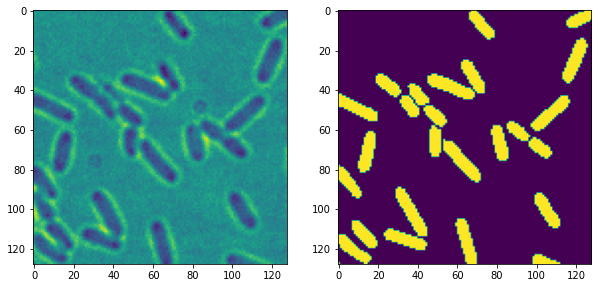

In [ ]:
ix = random.randint(0, len(X_train)-1)
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(X_train[ix,:,:])
plt.subplot(1,2,2)
plt.imshow(Y_train[ix,:,:])

# Building U-Net

Following JB's U-NET pipeline for the moment...

In [ ]:
#Each block of u-net architecture consist of two Convolution layers
# These two layers are written in a function to make our code clean
def conv2d_block(input_tensor, n_filters, kernel_size=3):
    # first layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size),
               padding="same")(input_tensor)
    x = Activation("relu")(x)
    x = BatchNormalization()(x)
    # second layer## add curves loss and acc

    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), 
               padding="same")(x)
    x = Activation("relu")(x)
    x = BatchNormalization()(x)

    # x = Dropout(rate=dropout_rate)(x)
    return x

In [ ]:
# The u-net architecture consists of contracting and expansive paths which
# shrink and expands the inout image respectivly. 
# Output image have the same size of input image
def get_unet(input_img, n_filters):
    # contracting path

    # RandomCrop(128, 128)

    c1 = conv2d_block(input_img, n_filters=n_filters*4, kernel_size=3) #The first block of U-net
    p1 = MaxPooling2D((2, 2)) (c1)

    c2 = conv2d_block(p1, n_filters=n_filters*8, kernel_size=3)
    p2 = MaxPooling2D((2, 2)) (c2)

    c3 = conv2d_block(p2, n_filters=n_filters*16, kernel_size=3)
    p3 = MaxPooling2D((2, 2)) (c3)

    c4 = conv2d_block(p3, n_filters=n_filters*32, kernel_size=3)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

    c5 = conv2d_block(p4, n_filters=n_filters*64, kernel_size=3)
    #p5 = MaxPooling2D(pool_size=(2, 2)) (c5)
    
    #c6 = conv2d_block(p5, n_filters=n_filters*128, kernel_size=3) # last layer on encoding path 
    
    # expansive path
    u7 = Conv2DTranspose(n_filters*64, (3, 3), strides=(2, 2), padding='same') (c5) #upsampling included
    u7 = concatenate([u7, c4])
    c7 = conv2d_block(u7, n_filters=n_filters*64, kernel_size=3)
    #c7 = Dropout(0.4) (c7)

    u8 = Conv2DTranspose(n_filters*32, (3, 3), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c3])
    c8 = conv2d_block(u8, n_filters=n_filters*32, kernel_size=3)
    #c8 = Dropout(0.35) (c8)

    u9 = Conv2DTranspose(n_filters*16, (3, 3), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c2])
    c9 = conv2d_block(u9, n_filters=n_filters*16, kernel_size=3)
    #c9 = Dropout(0.3) (c9)

    u10 = Conv2DTranspose(n_filters*8, (3, 3), strides=(2, 2), padding='same') (c9)
    u10 = concatenate([u10, c1])
    c10 = conv2d_block(u10, n_filters=n_filters*8, kernel_size=3)
    #c10 = Dropout(0.25) (c10)

    # u11 = Conv2DTranspose(n_filters*4, (3, 3), strides=(2, 2), padding='same') (c10)
    # u11 = concatenate([u11, c1], axis=3)
    # c11 = conv2d_block(u11, n_filters=n_filters*4, kernel_size=3)
    # c11 = Dropout(0.2) (c11)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid') (c10)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [ ]:
# the coefficient takes values in [0, 1], where 0 is the worst score, 1 is the best score
# the dice coefficient of two sets represented as vectors a, b ca be computed as (2 *|a b| / (a^2 + b^2))
def dice_coefficient(y_true, y_pred):
    eps = 1e-6
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    out = (2. * intersection) / (K.sum(y_true_f * y_true_f) + \
                                 K.sum(y_pred_f * y_pred_f) + eps)
    return out

def loss_dice_coefficient(y_true, y_pred):
    eps = 1e-6
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    y_true_f = float(y_true_f)
    y_pred_f = float(y_pred_f)
    intersection = K.sum(y_true_f * y_pred_f)
    out = 1 - (2. * intersection) / (K.sum(y_true_f * y_true_f) + \
                                     K.sum(y_pred_f * y_pred_f) + eps)
    return out

def weightedLoss(originalLossFunc, weightsList):

    def lossFunc(true, pred):

        axis = -1 #if channels last 
        #axis=  1 #if channels first


        #argmax returns the index of the element with the greatest value
        #done in the class axis, it returns the class index    
        classSelectors = K.argmax(true, axis=axis) 
            #if your loss is sparse, use only true as classSelectors

        #considering weights are ordered by class, for each class
        #true(1) if the class index is equal to the weight index   
        classSelectors = [K.equal(np.int64(i), classSelectors) for i in range(len(weightsList))]

        #casting boolean to float for calculations  
        #each tensor in the list contains 1 where ground true class is equal to its index 
        #if you sum all these, you will get a tensor full of ones. 
        classSelectors = [K.cast(x, K.floatx()) for x in classSelectors]

        #for each of the selections above, multiply their respective weight
        weights = [sel * w for sel,w in zip(classSelectors, weightsList)] 

        #sums all the selections
        #result is a tensor with the respective weight for each element in predictions
        weightMultiplier = weights[0]
        for i in range(1, len(weights)):
            weightMultiplier = weightMultiplier + weights[i]


        #make sure your originalLossFunc only collapses the class axis
        #you need the other axes intact to multiply the weights tensor
        loss = originalLossFunc(true,pred) 
        loss = loss * weightMultiplier

        return loss
    return lossFunc

In [ ]:
# Creating and Compiling the model
# error with concatenation: image shape must be a multiple of 32
input_img = Input((X_train.shape[1], X_train.shape[2],1), name='img')
model = get_unet(input_img, n_filters=4)

model.compile(optimizer=optimizer, 
              loss=loss_dice_coefficient, #"binary_crossentropy", #not binary_crossentropy since we are working with more than 2 classes
              metrics=[dice_coefficient])


#model.compile(optimizer=optimizer,
#                   loss=weightedLoss(loss_dice_coefficient, class_weights),
#                   metrics=[dice_coefficient])

model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 img (InputLayer)               [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_38 (Conv2D)             (None, 128, 128, 16  160         ['img[0][0]']                    
                                )                                                                 
                                                                                                  
 activation_36 (Activation)     (None, 128, 128, 16  0           ['conv2d_38[0][0]']              
                                )                                                           

# Using Data Augmentation

In [ ]:
def add_noise(img):
    '''Add random noise to an image'''
    noise = np.random.normal(0, np.random.uniform(0,0.005,1), img.shape)
    img += noise
    img = img / np.max(img)
    return img

In [ ]:
batch_size = 32
seed = 1

## DATA AUGMENTATION
X_train = np.reshape(X_train,(X_train.shape[0],X_train.shape[1],X_train.shape[2],1))
Y_train = np.reshape(Y_train,(Y_train.shape[0],Y_train.shape[1],Y_train.shape[2],1))
X_test = np.reshape(X_test,(X_test.shape[0],X_test.shape[1],X_test.shape[2],1))
Y_test = np.reshape(Y_test,(Y_test.shape[0],Y_test.shape[1],Y_test.shape[2],1))

# datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True, validation_split=0.3)
datagen = ImageDataGenerator(horizontal_flip=True, vertical_flip = True)# preprocessing_function=add_noise) # validation_split=0.3)
x_it_train = datagen.flow(X_train, batch_size=batch_size, seed=seed)
y_it_train = datagen.flow(Y_train, batch_size=batch_size, seed=seed)
train_generator = zip(x_it_train, y_it_train)

steps = int(X_train.shape[0] / batch_size)
print(steps)


3


(-0.5, 127.5, 127.5, -0.5)

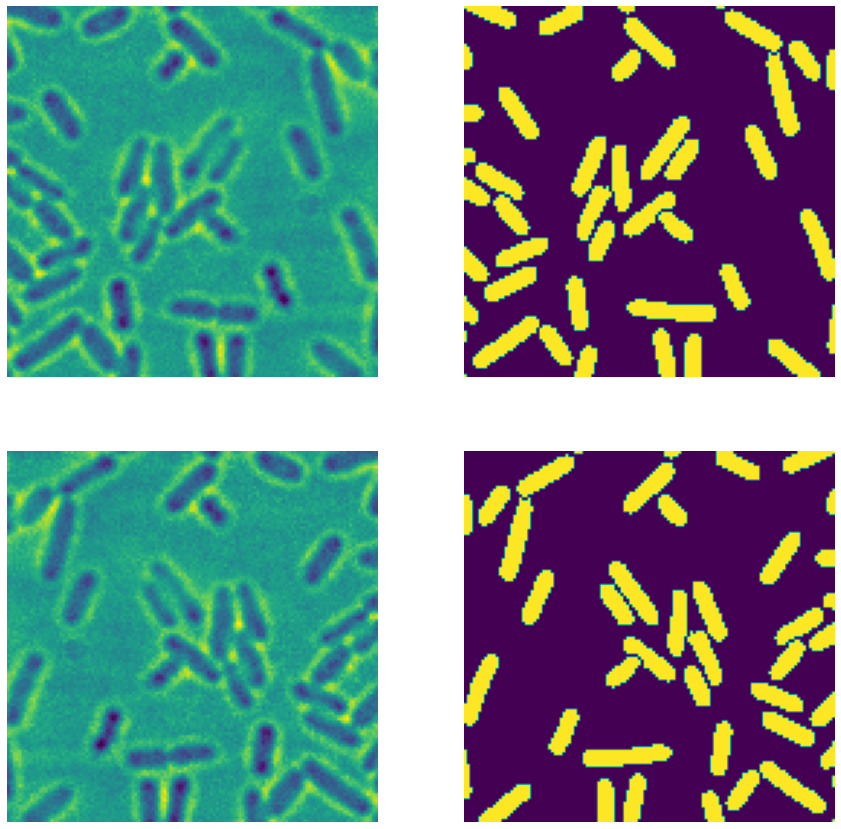

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15,15))
x_datagen = ImageDataGenerator(horizontal_flip=True, vertical_flip = True, preprocessing_function=add_noise) # validation_split=0.3)
y_datagen = ImageDataGenerator(horizontal_flip=True, vertical_flip = True) # validation_split=0.3)
seed=5

im = np.reshape(X_train[1,:,:],(1,X_train.shape[1],X_train.shape[2],1))
label = np.reshape(Y_train[1,:,:],(1,Y_train.shape[1],Y_train.shape[2],1))

x_it_train = x_datagen.flow(im, batch_size=1, seed=seed)
y_it_train = y_datagen.flow(label, batch_size=1, seed=seed)
train_generator = zip(x_it_train, y_it_train)

# generate the image
im_generated = next(train_generator)

# plot original images
ax[0,0].imshow(im[0,:,:,0])
ax[0,0].axis('off')
ax[0,1].imshow(label[0,:,:,0])
ax[0,1].axis('off')
 
# plot generated images
ax[1,0].imshow(im_generated[0][0,:,:,0])
ax[1,0].axis('off')
ax[1,1].imshow(im_generated[1][0,:,:,0])
ax[1,1].axis('off')

In [ ]:
#With data augmentation
results = model.fit(train_generator, 
                    epochs=150, 
                    validation_data=(X_test, Y_test),
                    steps_per_epoch = steps,
                    )

Epoch 1/150
3/3 [==============================] - 0s 192ms/step - loss: 0.0531 - dice_coefficient: 0.9472 - val_loss: 0.9750 - val_dice_coefficient: 0.0250
Epoch 2/150
3/3 [==============================] - 0s 130ms/step - loss: 0.0503 - dice_coefficient: 0.9495 - val_loss: 0.9721 - val_dice_coefficient: 0.0279
Epoch 3/150
3/3 [==============================] - 0s 130ms/step - loss: 0.0510 - dice_coefficient: 0.9499 - val_loss: 0.9566 - val_dice_coefficient: 0.0434
Epoch 4/150
3/3 [==============================] - 0s 165ms/step - loss: 0.0505 - dice_coefficient: 0.9495 - val_loss: 0.9265 - val_dice_coefficient: 0.0735
Epoch 5/150
3/3 [==============================] - 0s 165ms/step - loss: 0.0504 - dice_coefficient: 0.9498 - val_loss: 0.9511 - val_dice_coefficient: 0.0489
Epoch 6/150
3/3 [==============================] - 0s 132ms/step - loss: 0.0509 - dice_coefficient: 0.9493 - val_loss: 0.9811 - val_dice_coefficient: 0.0189
Epoch 7/150
3/3 [==============================] - 0s 130m

In [ ]:
#Without data augmentation
results = model.fit(X_train, Y_train, 
                    epochs=150, 
                    validation_data=(X_test, Y_test),
                    batch_size=32,
                    shuffle=True,
                    )
                    # validation_steps = validation_generator.samples // 32)

# tensorflow: do not specify batch size if data comes in the form of a generator

# results = model.fit(it_train, 
#                     epochs=300, 
#                     steps_per_epoch = steps,
#                     callbacks=[tensorboard_callback],
#                     validation_data = validation_generator)
                    # validation_steps = validation_generator.samples // 32)

Epoch 1/150
4/4 [==============================] - 3s 279ms/step - loss: 0.5642 - dice_coefficient: 0.5411 - val_loss: 1.3861 - val_dice_coefficient: 0.2624
Epoch 2/150
4/4 [==============================] - 1s 126ms/step - loss: 0.2876 - dice_coefficient: 0.7575 - val_loss: 2456.0579 - val_dice_coefficient: 0.2226
Epoch 3/150
4/4 [==============================] - 1s 126ms/step - loss: 0.2171 - dice_coefficient: 0.8277 - val_loss: 3831.2837 - val_dice_coefficient: 0.2226
Epoch 4/150
4/4 [==============================] - 1s 127ms/step - loss: 0.1672 - dice_coefficient: 0.8725 - val_loss: 9101.2910 - val_dice_coefficient: 0.2226
Epoch 5/150
4/4 [==============================] - 1s 125ms/step - loss: 0.1398 - dice_coefficient: 0.8922 - val_loss: 19122.3438 - val_dice_coefficient: 0.2226
Epoch 6/150
4/4 [==============================] - 1s 128ms/step - loss: 0.1161 - dice_coefficient: 0.9067 - val_loss: 25975.4941 - val_dice_coefficient: 0.2226
Epoch 7/150
4/4 [========================

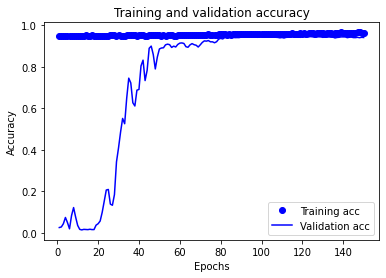

In [ ]:
history_dict = results.history

acc_values = history_dict['dice_coefficient']
val_acc_values = history_dict['val_dice_coefficient']

n = len(acc_values)
epochs = range(1, n+1)

plt.plot(epochs, acc_values, 'bo', label='Training acc')
plt.plot(epochs, val_acc_values, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

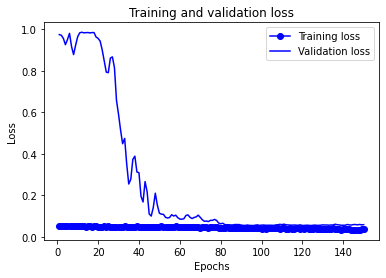

In [ ]:
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

plt.plot(epochs, loss_values, '-bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
model.evaluate(X_test,Y_test)

1/1 [==============================] - 0s 58ms/step - loss: 0.0563 - dice_coefficient: 0.9437


[0.05625414848327637, 0.9437458515167236]

In [ ]:
preds_test = model.predict(X_test, verbose=1)
# we apply a threshold on predicted mask (probability mask) to convert it to a binary mask.
preds_test_t = (preds_test > 0.5).astype(np.uint8) 

1/1 [==============================] - 0s 348ms/step


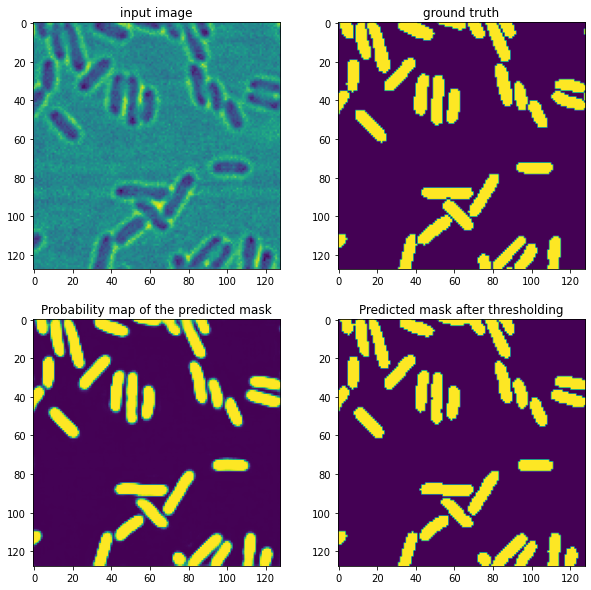

In [ ]:
ix = random.randint(0, len(X_test)-1)
# ix=6

fig = plt.figure(figsize=(10, 10))
plt.subplot(221)
plt.imshow(X_test[ix,:,:,0]) #data aug
plt.title("input image")
plt.subplot(222)
plt.imshow(np.squeeze(Y_test[ix, :, :])) #data aug
plt.title("ground truth")
plt.subplot(223)
# pred_argmax = np.argmax(preds_test[ix,:,:,:], axis=2)
# plt.imshow(np.squeeze(pred_argmax)) # data aug
plt.imshow(np.squeeze(preds_test[ix,:,:,0])) # data aug
plt.title("Probability map of the predicted mask")
plt.subplot(224)
plt.imshow(np.squeeze(preds_test_t[ix, :, :])) #data aug
plt.title("Predicted mask after thresholding")
# show the plot
plt.show()